<a href="https://colab.research.google.com/github/satoruk-icepp/MEG2XEC/blob/master/MEG2Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%writefile .comet.config
[comet]
api_key=mIel5ZAPOioTs0Cij75dSSQXs
logging_file = /tmp/comet.log
logging_file_level = info


Overwriting .comet.config


In [3]:
! [ ! -z "$COLAB_GPU" ] && pip install skorch comet_ml

In [0]:
from comet_ml import Experiment
from comet_ml.exceptions import InterruptedExperiment
from datetime import datetime
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR,StepLR,CyclicLR,CosineAnnealingLR
from torch.utils.data.dataset import Subset
# from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook
from scipy.optimize import curve_fit

In [0]:
# csv_data  = pd.read_csv('/content/drive/My Drive/MEG2CW/fout.csv')
# names=['E','U','V','W','PT','PP','UR','VR','WR']
# PMnames = ['PM%d'%(i) for i in range(4760)]
# names = names+PMnames
# csv_data  = pd.read_csv('/content/drive/My Drive/MEG2CW/fout_norm.csv',names=names)
csv_data  = pd.read_csv('/content/drive/My Drive/MEG2CW/fout_norm.csv')

In [6]:
experiment = Experiment(project_name="CWreg",log_code=True)
curtime = datetime.now().strftime("%Y%m%d-%H%M%S")
experiment.set_name("%s"%(curtime))
params={'batch_size' : 200,
        'train_size':20000,
        'val_size':1000,
        'dropout_conv':0.4,
        'dropout_fc':0.05,
        'optim':"Adam",
        'weight_decay':1e-05,
        'Nresblock':5,
        'Nsd':0,
        'Wthreshold':np.log(0.2+1e-02)/2.5+1,
        'ethreshold':0.0,
        'weightstd':0.01,
        'Nlayer':32,
        'Nfc':0,
        'Nfcnodes':128,
        'Nepoch':5000,
        # 'learning_rate':0.0000001,# for lr_test
        # 'LRgamma':10,# for lr_test
        # 'stepsize_lr':1, # for lr_test
        # "LRtype":"Step",
        'learning_rate':0.01,
        # 'LRgamma':0.3,
        'LRgamma':0.995,
        'milestones':[200,400,600,800,1000],
        # "LRtype":"MStep",
        # "LRtype":"Cyclic",
        # "LRtype":"CosA",
        "LRtype":"CosExp",
        'stepsize_lr':100,
        'stepsize_lr_down':29,
        
        'base_lr':0.000001,
        # 'max_lr':0.005,
        
        'UseLPF':True
}
experiment.log_parameters(params)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/satoruk-icepp/cwreg/7c8ef54dee1e48e1b69346b820baef05



In [0]:
device = torch.device('cuda:0')

In [8]:
print(csv_data.shape)
print(params['Wthreshold'])
# csv_data = csv_data[csv_data['w']<params['Wthreshold']]
csv_data = csv_data[csv_data['Energy']>params['ethreshold']]
csv_data

(88682, 4774)
0.3757409006941327


,Energy,EneRec,u,v,w,ptheta,pphi,smag,stheta,sphi,urec,vrec,wrec,PM_0,PM_1,PM_2,PM_3,PM_4,PM_5,PM_6,PM_7,PM_8,PM_9,PM_10,PM_11,PM_12,PM_13,PM_14,PM_15,PM_16,PM_17,PM_18,PM_19,PM_20,PM_21,PM_22,PM_23,PM_24,PM_25,PM_26,...,PM_4721,PM_4722,PM_4723,PM_4724,PM_4725,PM_4726,PM_4727,PM_4728,PM_4729,PM_4730,PM_4731,PM_4732,PM_4733,PM_4734,PM_4735,PM_4736,PM_4737,PM_4738,PM_4739,PM_4740,PM_4741,PM_4742,PM_4743,PM_4744,PM_4745,PM_4746,PM_4747,PM_4748,PM_4749,PM_4750,PM_4751,PM_4752,PM_4753,PM_4754,PM_4755,PM_4756,PM_4757,PM_4758,PM_4759,flag
0,0.881000,0.906775,0.647425,0.402845,0.406430,-0.107640,-0.157894,0.026197,0.372978,-0.403479,0.611859,0.407013,0.386388,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0001,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,0.0002,0.0001,0.0000,0.0001,0.0002,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0003,0.0002,0.0029,0.0032,0.0014,0.0026,0.0033,0.0042,0.0031,0.0025,0.0039,0.0015,0.0024,0.0005,0.0016,0.0006,0.0017,0.0020,0.0014,0.0012,0
1,0.771196,0.753837,-0.550071,0.363598,-0.479323,0.103068,-0.142511,0.149667,0.009527,-0.171185,-0.551514,0.366742,-0.548834,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0028,0.0017,0.0033,0.0035,0.0032,0.0022,0.0018,0.0023,0.0010,0.0021,0.0012,0.0019,0.0019,0.0022,0.0011,0.0010,0.0016,0.0011,0
2,0.881000,0.908030,0.224333,-0.437471,0.610209,-0.035703,0.171466,0.106931,-0.071142,0.283655,0.228618,-0.453216,0.693381,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0033,0.0041,0.0037,0.0039,0.0036,0.0028,0.0020,0.0009,0.0010,0.0012,0.0019,0.0019,0.0023,0.0027,0.0029,0.0035,0.0024,0.0026,0.0024,0.0017,0.0014,0.0025,0.0014,0.0016,0.0013,0.0008,0.0015,0.0019,0.0021,0.0012,0.0026,0.0026,0.0021,0.0033,0.0022,0.0028,0.0032,0.0033,0.0056,0
3,0.750934,0.762915,0.642363,0.384732,0.575611,-0.100793,-0.150795,0.110528,0.355876,-0.884711,0.591816,0.380710,0.581872,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,0.0000,0.0000,0.0001,0.0000,0.0001,0.0002,0.0001,...,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0003,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0002,0.0000,0.0000,0.0020,0.0043,0.0018,0.0022,0.0020,0.0035,0.0038,0.0016,0.0023,0.0016,0.0019,0.0018,0.0013,0.0012,0.0018,0.0015,0.0019,0.0013,0
4,0.881000,0.930512,-0.244407,0.660570,0.186308,0.044294,-0.258908,0.104042,0.067992,-0.113370,-0.247431,0.654285,0.209709,0.0000,0.0002,0.0001,0.0001,0.0002,0.0004,0.0001,0.0001,0.0003,0.0005,0.0005,0.0005,0.0002,0.0003,0.0004,0.0003,0.0001,0.0002,0.0004,0.0005,0.0003,0.0004,0.0001,0.0001,0.0003,0.0003,0.0001,...,0.0000,0.0001,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0021,0.0017,0.0020,0.0012,0.0009,0.0012,0.0014,0.0009,0.0012,0.0008,0.0011,0.0008,0.0009,0.0002,0.0003,0.0005,0.0004,0.0005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88677,0.847906,0.896458,-0.381009,0.677956,0.529823,0.062263,-0.265723,0.024990,0.233780,-0.255067,-0.391716,0.679765,0.501417,0.0005,0.0004,0.0006,0.0002,0.0004,0.0001,0.0001,0.0

In [0]:
csv_data_numpy = csv_data.to_numpy()
del csv_data

In [0]:
Energy  = csv_data_numpy[:,0]
EneREC  = csv_data_numpy[:,1]
UVW     = csv_data_numpy[:,2:5]
DIR     = csv_data_numpy[:,5:7]
SHW     = csv_data_numpy[:,7:10]
UVWREC  = csv_data_numpy[:,10:13]
PMResponse = csv_data_numpy[:,13:4773]

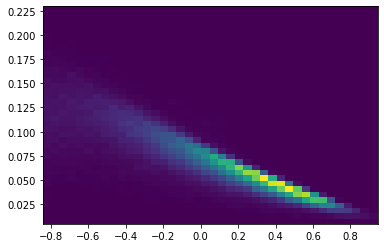

In [11]:
Energy     = Energy.reshape(-1,1)
EneREC     = EneREC.reshape(-1,1)
PMResponse_MPPC,PMResponse_PMT = np.split(PMResponse,[4092],axis=1)
PMResponse_MPPC = PMResponse_MPPC.reshape(-1,93,44)
indx_U = np.arange(-21.5,22.5)
indx_V = np.arange(-46,47)
# for i in np.arange(-21.5,22.5):
PMU = (np.dot(np.sum(PMResponse_MPPC[:],axis=1),indx_U)/np.sum(np.sum(PMResponse_MPPC[:],axis=1),axis=1))/22
PMV = (np.dot(np.sum(PMResponse_MPPC[:],axis=2),indx_V)/np.sum(np.sum(PMResponse_MPPC[:],axis=2),axis=1))/46.5
PMU = PMU.reshape(-1,1)
PMV = PMV.reshape(-1,1)
PMURMS = np.sqrt(np.mean(np.square(np.sum(PMResponse_MPPC[:],axis=1)),axis=1)).reshape(-1,1)
PMVRMS = np.sqrt(np.mean(np.square(np.sum(PMResponse_MPPC[:],axis=2)),axis=1)).reshape(-1,1)
plt.hist2d(UVW[:,2],PMURMS.reshape(-1),bins=[40,40])
ADD = np.concatenate((PMU,PMV,PMURMS,PMVRMS),axis=1)
COSST = 0.8*np.cos(np.pi*SHW[:,1]).reshape(-1,1)
SINST = 0.8*np.sin(np.pi*SHW[:,1]).reshape(-1,1)
COSSP = 0.8*np.cos(np.pi*SHW[:,2]).reshape(-1,1)
SINSP = 0.8*np.sin(np.pi*SHW[:,2]).reshape(-1,1)
SHW = np.concatenate((SHW[:,0].reshape(-1,1),COSST,SINST,COSSP,SINSP),axis=1)
# print(ADD)

In [0]:
# UVW = np.divide(UVW,[2,1,16])
# UVWREC = np.divide(UVWREC,[2,1,16])

In [0]:
del csv_data_numpy

In [0]:
PMResponse = PMResponse.reshape(-1,4760)
# PMResponse = PMResponse/PMResponseScale

In [0]:
Energy        = torch.tensor(Energy).float()
EneREC        = torch.tensor(EneREC).float()
UVW           = torch.tensor(UVW).float()
DIR           = torch.tensor(DIR).float()
SHW           = torch.tensor(SHW).float()
ADD           = torch.tensor(ADD).float()
UVWREC        = torch.tensor(UVWREC).float()
PMResponse    = torch.tensor(PMResponse).float()

In [16]:
# from torch.utils.data.dataset import Subset
BATCH_SIZE = params["batch_size"]
calo_dataset    = utils.TensorDataset(Energy,EneREC,UVW,UVWREC,DIR,SHW,ADD,PMResponse)
data_size =  len(calo_dataset)
full_size = int(data_size/1000)*1000
val_size = 500
print(data_size)
# train_dataset = Subset(calo_dataset,list(range(0,full_size-val_size)))
# val_dataset = Subset(calo_dataset,list(range(full_size-val_size,full_size)))
train_dataset = Subset(calo_dataset,list(range(0,params["train_size"])))
val_dataset = Subset(calo_dataset,list(range(params["train_size"],params["train_size"]+params["val_size"])))
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              pin_memory=True, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=len(val_dataset), 
                                              pin_memory=True, shuffle=True)


88682


In [0]:
def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self,input_size):
        super(ResidualBlock, self).__init__()        
        self.conv1 = nn.Conv2d(input_size,input_size,3,padding=1)
        self.conv2 = nn.Conv2d(input_size,input_size,3,padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv1.out_channels)
        self.bn2 = nn.BatchNorm2d(self.conv2.out_channels)        
        self.activation = nn.LeakyReLU(0.0)
    def forward(self,xraw):
        x = self.activation(self.bn1(self.conv1(xraw)))
        x = self.activation(self.bn2(self.conv2(x))+xraw)
        return x

In [0]:
class DoubleSize(nn.Module):
    def __init__(self):
        super(DoubleSize, self).__init__()
        eps = 1e-3
        self.ups = nn.Upsample(scale_factor = 2,mode = 'bilinear',align_corners=False )
    def forward(self,x):
        return self.ups(x)

In [0]:
class Regressor(nn.Module):
    def __init__(self, dropout_conv =0.0,dropout_fc=0.0,Nresblock=0,Nsd=0,Nlayer=32,Nfc=4,Nfcnodes=256):
        super(Regressor, self).__init__()
        # self.rconv1 = ReducedConv(1,Nlayer,)
        self.conv1 = nn.Conv2d(
            1, 
            Nlayer, 
            kernel_size=(6,4), 
            stride = (3,2), 
            padding = (3,3)
            )#(93+6,44+6)->32,24
        self.conv2 = nn.Conv2d(
            self.conv1.out_channels, 
            self.conv1.out_channels*2, 
            kernel_size=(3, 4), 
            stride=(3,2)
            ,padding = (2,1)
        )#32*24->12*23
        self.conv3 = nn.Conv2d(
            self.conv2.out_channels, 
            self.conv2.out_channels*2, 
            2
            ,stride=2
        )#12*12->6*6
        self.conv4 = nn.Conv2d(
            self.conv3.out_channels, 
            self.conv3.out_channels*2, 
            2
            ,stride=2
        )#12*12->6*6
        self.convsd = nn.Conv2d(
            self.conv1.out_channels, 
            self.conv1.out_channels, 
            3,
            padding=1
        )#6*6->6*3 
        self.rb = ResidualBlock(self.conv1.out_channels)
        # self.fcstart = nn.Linear(self.conv3.out_channels*18+668+7,Nfcnodes)
        self.fcstart = nn.Linear(self.conv4.out_channels*9+668+7,Nfcnodes)
        self.Nfc = Nfc
        self.fc=[nn.Linear(self.fcstart.out_features//2**i,self.fcstart.out_features//2**(i+1)).to(device) for i in range(self.Nfc)]
        self.fcend = nn.Linear(self.fcstart.out_features//2**(Nfc),9)
        
        self.bn1 = nn.BatchNorm2d(self.conv1.out_channels)
        self.bn2 = nn.BatchNorm2d(self.conv2.out_channels)
        self.bn3 = nn.BatchNorm2d(self.conv3.out_channels)
        self.bn4 = nn.BatchNorm2d(self.conv4.out_channels)
        self.dropout1 = nn.Dropout(dropout_conv)
        self.dropoutfc = nn.Dropout(dropout_fc)
        self.Nresblock = Nresblock
        self.Nsd = Nsd
        
    def forward(self, x, add):
        x = x.view(x.shape[0],-1)
        x_mppc,x_pmt = torch.split(x,4092,dim=1)
        x_mppc = x_mppc.view(x_mppc.shape[0],1,93,44)
        x_mppc = F.relu(self.bn1(self.conv1(x_mppc)))
        for i in range(self.Nresblock):
            x_mppc = self.dropout1(self.rb(x_mppc))
        for i in range(self.Nsd):
            x_mppc = F.relu(self.dropout1(self.bn1(self.convsd(x_mppc))))
        x_mppc = F.relu(self.dropout1(self.bn2(self.conv2(x_mppc))))
        x_mppc = F.relu(self.dropout1(self.bn3(self.conv3(x_mppc))))
        x_mppc = F.relu(self.dropout1(self.bn4(self.conv4(x_mppc))))
        
        x_mppc = x_mppc.view(x_mppc.shape[0],self.conv4.out_channels*9)
        x = torch.cat([x_mppc,x_pmt,add],dim=1)
        x = F.relu(self.fcstart(x))
        for i in range(self.Nfc):
            x = F.relu(self.dropoutfc(self.fc[i](x)))
        # x = F.relu(self.dropoutfc(self.fc3(x)))
        # x = F.relu(self.dropoutfc(self.fc4(x)))
        x = self.fcend(x)
        return torch.tanh(x)
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [21]:
model = Regressor(
    params["dropout_conv"],
    params["dropout_fc"],
    params["Nresblock"],
    params["Nsd"],
    params['Nlayer'],
    params['Nfc'],
    params['Nfcnodes']
    ).to(device)
    
print(model)
model.weight_init(mean=0.0, std=params['weightstd'])

Regressor(
  (conv1): Conv2d(1, 32, kernel_size=(6, 4), stride=(3, 2), padding=(3, 3))
  (conv2): Conv2d(32, 64, kernel_size=(3, 4), stride=(3, 2), padding=(2, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
  (convsd): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rb): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.0)
  )
  (fcstart): Linear(in_features=2979, out_features=128, bias=True)
  (fcend): Linear(in_features=128, out_features=9, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [0]:
# Energy_,UVW_,UVWREC_,DIR_,ADD_,PMResponse_ = next(iter(train_dataloader))
# writer = SummaryWriter()
# writer.add_graph(model, (PMResponse_.to(device), torch.cat([ADD_.to(device),UVWREC_.to(device)],dim=1)))
# writer.close()

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir logs/tensorboard

In [0]:
from torch.optim.lr_scheduler import _LRScheduler

class CosineExpLR(_LRScheduler):
    def __init__(self, optimizer, T_max, eta_min=0, gamma=0.99, last_epoch=-1):
            self.T_max = T_max
            self.eta_min = eta_min
            # self.decayconst = decayconst
            self.gamma = gamma
            super(CosineExpLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.gamma ** self.last_epoch*(self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2)
                for base_lr in self.base_lrs]

In [0]:
# learning_rate = 0.001
# opt = optim.Adam(regressor.parameters(), lr=learning_rate)
opt = optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
if params["LRtype"]=="Cyclic":
    scheduler = CyclicLR(opt, params["base_lr"],params["learning_rate"],
                         step_size_up=params["stepsize_lr"],
                         step_size_down=params["stepsize_lr_down"],
                         cycle_momentum=False,mode="exp_range",gamma = params["LRgamma"])
elif params["LRtype"]=="MStep":
    scheduler = MultiStepLR(opt, milestones=params["milestones"], gamma=params["LRgamma"])
elif params["LRtype"]=="Step":
    scheduler = StepLR(opt,step_size=params["stepsize_lr"],gamma=params["LRgamma"])
elif params["LRtype"]=="CosA":
    scheduler = CosineAnnealingLR(opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"])
elif params["LRtype"]=="CosExp":
    scheduler = CosineExpLR(opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"],gamma = params["LRgamma"])

In [0]:
Energy_mean, UVW_mean, DIR_mean,SHW_mean = Energy.mean(dim=0).to(device), UVW.mean(dim=0).to(device), DIR.mean(dim=0).to(device),SHW.mean(dim=0).to(device)
UVWE_mean = torch.cat([UVW_mean,Energy_mean]).to(device)
UVWESHW_mean = torch.cat([UVW_mean,Energy_mean,SHW_mean]).to(device)
UVWDIR_mean = torch.cat([UVW_mean, DIR_mean]).to(device)
def metric_relative_mse(y_pred,y_true):
    y_true_mean = y_true.mean(dim=0)
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVWE_mean).pow(2).mean(dim=0)).sum()).sqrt()
    return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVWESHW_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVWESHW_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVW_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true[:,2] - y_pred[:,2]).pow(2).mean(dim=0) / (y_true[:,2] - UVW_mean[2]).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVWDIR_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - Energy_mean).pow(2).mean(dim=0)).sum()).sqrt()

In [0]:
# loss_fn = torch.nn.SmoothL1Loss().to(device)
loss_fn = torch.nn.L1Loss().to(device)

In [0]:
ranges=[2,2,4,2,3,50,50]

def run_training(epochs=100):
    # iterating over epochs...
    ibatch = 0
    for epoch in tqdm(range(epochs)):
        first = True
        with experiment.train():
            for Energy_b, EneREC_b, UVW_b, UVWREC_b, DIR_b, SHW_b, ADD_b, PMResponse_b in train_dataloader:
            # moving them to device(for example, cuda-device)
                Energy_b, EneREC_b, UVW_b, UVWREC_b, DIR_b, SHW_b, ADD_b, PMResponse_b = Energy_b.to(device), \
                                                EneREC_b.to(device), \
                                                UVW_b.to(device), \
                                                UVWREC_b.to(device), \
                                                DIR_b.to(device), \
                                                SHW_b.to(device), \
                                                ADD_b.to(device), \
                                                PMResponse_b.to(device)

    #             pred = regressor(EnergyDeposit_b)
                model.train()
                UVWDIR_b = torch.cat([UVW_b,DIR_b],dim=1)
                UVWDIRrec_b = torch.cat([UVWREC_b,DIR_b],dim=1)
                if params["UseLPF"]:
                    pred = model(PMResponse_b,torch.cat([ADD_b,UVWREC_b],dim=1))
                else:
                    pred = model(PMResponse_b,ADD_b)
                loss            = loss_fn(pred, torch.cat([UVW_b,Energy_b,SHW_b],dim=1))
                loss_rec        = loss_fn(torch.cat([UVWREC_b,EneREC_b,SHW_b],dim=1), torch.cat([UVW_b,Energy_b,SHW_b],dim=1))
                # loss        = loss_fn(pred, UVW_b)
                # loss_rec    = loss_fn(UVWREC_b, UVW_b)
                # loss        = loss_fn(pred, Energy_b)

                # model.train()
                opt.zero_grad()
                loss.backward()
                opt.step()
                # if params["LRtype"]=="Cyclic":
                #     scheduler.step()
                ibatch+=1
            experiment.log_metric("learning_rate", scheduler.get_lr(),step=epoch)
            # if params["LRtype"]!="Cyclic":
            scheduler.step()
            with torch.no_grad():
                model.eval()
                if params["UseLPF"]:
                    pred = model(PMResponse_b,torch.cat([ADD_b,UVWREC_b],dim=1))
                else:
                    pred = model(PMResponse_b,ADD_b)
                # train_mse       = metric_relative_mse(pred, UVW_b).item()
                # train_mse_rec   = metric_relative_mse(UVWREC_b, UVW_b).item()
                train_mse            = metric_relative_mse(pred, torch.cat([UVW_b,Energy_b,SHW_b],dim=1)).item()
                train_mse_rec        = metric_relative_mse(torch.cat([UVWREC_b,EneREC_b,SHW_b],dim=1), torch.cat([UVW_b,Energy_b,SHW_b],dim=1)).item()

            # if epoch%10==0:
            #     plt.figure(figsize=(20,12))
            #     grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)
            #     for idim in range(3):
            #         plt.subplot(grid[2,idim])
            #         plt.hist2d(UVW_b[:,2].cpu().detach().numpy(),UVW_b[:,idim].cpu().detach().numpy()-pred[:,idim].cpu().detach().numpy(),
            #                 range=[[-1,1],[-0.2,0.2]],
            #                 bins = [40,40]
            #                 )
            
            
            experiment.log_metric("train_loss", loss.item(),step=epoch)
            experiment.log_metric("train_mse", train_mse,step=epoch)
            experiment.log_metric("train_loss_rec", loss_rec.item(),step=epoch)
            experiment.log_metric("train_mse_rec", train_mse_rec,step=epoch)
        # scheduler.step()
        with experiment.test():
            for Energy_b, EneREC_b,  UVW_b, UVWREC_b, DIR_b, SHW_b, ADD_b, PMResponse_b in val_dataloader:
        # moving them to device(for example, cuda-device)
                Energy_b, EneREC_b,  UVW_b, UVWREC_b, DIR_b, SHW_b, ADD_b, PMResponse_b = Energy_b.to(device), \
                                                EneREC_b.to(device), \
                                                UVW_b.to(device), \
                                                UVWREC_b.to(device), \
                                                DIR_b.to(device), \
                                                SHW_b.to(device), \
                                                ADD_b.to(device), \
                                                PMResponse_b.to(device)

                break

    #             pred = regressor(EnergyDeposit_b)
            with torch.no_grad():
                model.eval()
                # UVWDIR_b = torch.cat([UVW_b,DIR_b],dim=1)
                # UVWDIRrec_b = torch.cat([UVWREC_b,DIR_b],dim=1)
                # pred = model(PMResponse_b,UVWREC_b)
                # pred = model(PMResponse_b,torch.zeros(UVW_b.shape[0],3).to(device))
                # pred = model(PMResponse_b,ADD_b)
                if params["UseLPF"]:
                    pred = model(PMResponse_b,torch.cat([ADD_b,UVWREC_b],dim=1))
                else:
                    pred = model(PMResponse_b,ADD_b)
                # pred = model(PMResponse_b,torch.cat([ADD_b,UVWREC_b],dim=1))
                # val_loss        = loss_fn(pred, UVW_b)
                # val_loss_rec    = loss_fn(UVWREC_b, UVW_b)
                # val_mse       = metric_relative_mse(pred, UVW_b).item()
                # val_mse_rec   = metric_relative_mse(UVWREC_b, UVW_b).item()
                # val_loss            = loss_fn(pred, torch.cat([UVW_b,Energy_b],dim=1))
                # val_loss_rec        = loss_fn(torch.cat([UVWREC_b,EneREC_b],dim=1), torch.cat([UVW_b,Energy_b],dim=1))
                val_loss            = loss_fn(pred, torch.cat([UVW_b,Energy_b,SHW_b],dim=1))
                val_loss_rec        = loss_fn(torch.cat([UVWREC_b,EneREC_b,SHW_b],dim=1), torch.cat([UVW_b,Energy_b,SHW_b],dim=1))
                val_mse            = metric_relative_mse(pred, torch.cat([UVW_b,Energy_b,SHW_b],dim=1)).item()
                val_mse_rec        = metric_relative_mse(torch.cat([UVWREC_b,EneREC_b,SHW_b],dim=1), torch.cat([UVW_b,Energy_b,SHW_b],dim=1)).item()
                
                # val_mse   = metric_relative_mse(pred, Energy_b).item()
                # val_mse   = 0
            experiment.log_metric("val_loss", val_loss.item(),step=epoch)
            experiment.log_metric("val_loss_rec", val_loss_rec.item(),step=epoch)
            experiment.log_metric("val_mse", val_mse,step=epoch)
            experiment.log_metric("val_mse_rec", val_mse_rec,step=epoch)
            resolution_u = 40*np.sqrt(np.mean((UVW_b[:,0].cpu().detach().numpy()-pred[:,0].cpu().detach().numpy())**2))
            resolution_v = 80*np.sqrt(np.mean((UVW_b[:,1].cpu().detach().numpy()-pred[:,1].cpu().detach().numpy())**2))
            resolution_w = np.sqrt(np.mean((
                40*(np.exp((UVW_b[:,2].cpu().detach().numpy()-1)*2.5)-0.01)-
                40*(np.exp((pred[:,2].cpu().detach().numpy()-1)*2.5)-0.01)
                )**2))
            
            resolution_u_lpf = 40*np.sqrt(np.mean((UVW_b[:,0].cpu().detach().numpy()-UVWREC_b[:,0].cpu().detach().numpy())**2))
            resolution_v_lpf = 80*np.sqrt(np.mean((UVW_b[:,1].cpu().detach().numpy()-UVWREC_b[:,1].cpu().detach().numpy())**2))
            resolution_w_lpf = np.sqrt(np.mean((
                40*(np.exp((UVW_b[:,2].cpu().detach().numpy()-1)*2.5)-0.01)-
                40*(np.exp((UVWREC_b[:,2].cpu().detach().numpy()-1)*2.5)-0.01)
                )**2))
            resolution_e     = 20*np.sqrt(np.mean((Energy_b[:,0].cpu().detach().numpy()-pred[:,3].cpu().detach().numpy())**2))
            resolution_e_raw = 20*np.sqrt(np.mean((Energy_b[:,0].cpu().detach().numpy()-EneREC_b[:,0].cpu().detach().numpy())**2))
            dshwl = SHW_b[:,0].cpu().detach().numpy()-pred[:,4].cpu().detach().numpy()
            dshwt = np.arctan2(SHW_b[:,1].cpu().detach().numpy(),SHW_b[:,2].cpu().detach().numpy())-np.arctan2(pred[:,5].cpu().detach().numpy(),pred[:,6].cpu().detach().numpy())
            dshwp = np.arctan2(SHW_b[:,3].cpu().detach().numpy(),SHW_b[:,4].cpu().detach().numpy())-np.arctan2(pred[:,7].cpu().detach().numpy(),pred[:,8].cpu().detach().numpy())
            resolution_shwl = 40*np.sqrt(np.mean((dshwl)**2))
            resolution_shwt = 180/math.pi*np.sqrt(np.mean((dshwt[SHW_b[:,0].cpu().detach().numpy()>0.01])**2,axis=0))
            resolution_shwp = 180/math.pi*np.sqrt(np.mean((dshwp[SHW_b[:,0].cpu().detach().numpy()>0.01])**2,axis=0))
            # fraction = 0
            # for i in range(len(Energy_b)):
            #     if 180/math.pi*abs(np.arctan2(SHW_b[i,3].cpu().detach().numpy(),SHW_b[i,4].cpu().detach().numpy())-
            #                     np.arctan2(pred[i,7].cpu().detach().numpy(),pred[i,8].cpu().detach().numpy()))>50:
            #         print(180/math.pi*abs(np.arctan2(SHW_b[i,3].cpu().detach().numpy(),SHW_b[i,4].cpu().detach().numpy())-
            #                     np.arctan2(pred[i,7].cpu().detach().numpy(),pred[i,8].cpu().detach().numpy())))
            #         fraction+=1/float(len(Energy_b))
            # print(fraction)
            experiment.log_metric("e_resolution"    , resolution_e    ,step=epoch)
            experiment.log_metric("e_resolution_raw", resolution_e_raw,step=epoch)
            # resolution     =[np.sqrt(np.mean((UVW_b[:,idim].cpu().detach().numpy()-pred[:,idim].cpu().detach().numpy())**2)) for idim in range(3)]
            # resolution_lpf =[np.sqrt(np.mean((UVW_b[:,idim].cpu().detach().numpy()-UVWREC_b[:,idim].cpu().detach().numpy())**2)) for idim in range(3)]
            experiment.log_metric("u_resolution", resolution_u,step=epoch)
            experiment.log_metric("v_resolution", resolution_v,step=epoch)
            experiment.log_metric("w_resolution", resolution_w,step=epoch)
            experiment.log_metric("u_resolution_lpf", resolution_u_lpf,step=epoch)
            experiment.log_metric("v_resolution_lpf", resolution_v_lpf,step=epoch)
            experiment.log_metric("w_resolution_lpf", resolution_w_lpf,step=epoch)
            experiment.log_metric("shwl_resolution"    , resolution_shwl    ,step=epoch)
            experiment.log_metric("shwt_resolution"    , resolution_shwt    ,step=epoch)
            experiment.log_metric("shwp_resolution"    , resolution_shwp    ,step=epoch)
        if epoch%10==0:
            plt.figure(figsize=(28,12))
            grid = plt.GridSpec(2, 7, wspace=0.4, hspace=0.3)
            for idim in range(7):
                if idim==0:
                    plt.subplot(grid[0,idim])
                    plt.hist(UVW_b[:,idim].cpu().detach().numpy()*40-
                             pred[:,idim].cpu().detach().numpy()*40,
                             histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2)
                    plt.hist(UVW_b[:,idim].cpu().detach().numpy()*40-
                             UVWREC_b[:,idim].cpu().detach().numpy()*40,
                             histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='r',fill=False,edgecolor='r',lw=2)
                    plt.title("%f"%(resolution_u))
                    plt.subplot(grid[1,idim])
                    plt.hist2d(40*(np.exp((UVW_b[:,2].cpu().detach().numpy()-1)*2.5)-0.01),
                               40*(UVW_b[:,idim].cpu().detach().numpy()-pred[:,idim].cpu().detach().numpy()),
                        range=[[0,10],[-ranges[idim],ranges[idim]]],
                        bins = [40,40],
                            norm=LogNorm()
                        )
                elif idim==1:
                    plt.subplot(grid[0,idim])
                    plt.hist(UVW_b[:,idim].cpu().detach().numpy()*80-
                             pred[:,idim].cpu().detach().numpy()*80,
                             histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2)
                    plt.hist(UVW_b[:,idim].cpu().detach().numpy()*80-
                             UVWREC_b[:,idim].cpu().detach().numpy()*80,
                             histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='r',fill=False,edgecolor='r',lw=2)
                    plt.title("%f"%(resolution_v))
                    plt.subplot(grid[1,idim])
                    plt.hist2d(40*(np.exp((UVW_b[:,2].cpu().detach().numpy()-1)*2.5)-0.01),
                               80*(UVW_b[:,idim].cpu().detach().numpy()-pred[:,idim].cpu().detach().numpy()),
                        range=[[0,10],[-ranges[idim],ranges[idim]]],
                        bins = [40,40],
                            norm=LogNorm()
                        )
                elif idim==2:
                    plt.subplot(grid[0,idim])
                    plt.hist(40*(np.exp((UVW_b[:,idim].cpu().detach().numpy()-1)*2.5)-0.01)-
                             40*(np.exp((pred[:,idim].cpu().detach().numpy()-1)*2.5)-0.01),
                             histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2)
                    plt.hist(40*(np.exp((UVW_b[:,idim].cpu().detach().numpy()-1)*2.5)-0.01)-
                             40*(np.exp((UVWREC_b[:,idim].cpu().detach().numpy()-1)*2.5)-0.01)
                             ,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='r',fill=False,edgecolor='r',lw=2)
                    plt.title("%f"%(resolution_w))
                    plt.subplot(grid[1,idim])
                    plt.hist2d(40*(np.exp((UVW_b[:,idim].cpu().detach().numpy()-1)*2.5)-0.01),
                                40*(np.exp((UVW_b[:,idim].cpu().detach().numpy()-1)*2.5)-0.01)-
                             40*(np.exp((pred[:,idim].cpu().detach().numpy()-1)*2.5)-0.01),
                            range=[[0,10],[-ranges[idim],ranges[idim]]],
                            bins = [40,40],
                            norm=LogNorm()
                            )
                elif idim==3:
                    plt.subplot(grid[0,idim])
                    plt.hist(20*(Energy_b[:,0].cpu().detach().numpy()-
                             pred[:,idim].cpu().detach().numpy()),
                             histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2)
                    plt.hist(20*(Energy_b[:,0].cpu().detach().numpy()-
                             EneREC_b[:,0].cpu().detach().numpy()),
                             histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='r',fill=False,edgecolor='r',lw=2)
                    plt.title("%f"%(resolution_e))
                    plt.subplot(grid[1,idim])
                    plt.hist2d(40*(np.exp((UVW_b[:,2].cpu().detach().numpy()-1)*2.5)-0.01),
                               20*(Energy_b[:,0].cpu().detach().numpy()-pred[:,idim].cpu().detach().numpy()),
                        range=[[0,10],[-ranges[idim],ranges[idim]]],
                        bins = [40,40],
                            norm=LogNorm()
                        )
                elif idim==4:
                    plt.subplot(grid[0,idim])
                    plt.hist(40*(SHW_b[:,0].cpu().detach().numpy()-
                             pred[:,idim].cpu().detach().numpy()),
                             histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2)
                    plt.title("%f"%(resolution_shwl))
                    plt.subplot(grid[1,idim])
                    plt.hist2d(40*(np.exp((UVW_b[:,2].cpu().detach().numpy()-1)*2.5)-0.01),
                               40*(SHW_b[:,0].cpu().detach().numpy()-pred[:,idim].cpu().detach().numpy()),
                        range=[[0,10],[-ranges[idim],ranges[idim]]],
                        bins = [40,40],
                            norm=LogNorm()
                        )
                elif idim==5:
                    plt.subplot(grid[0,idim])
                    plt.hist(
                        180/math.pi*(
                        np.arctan2(SHW_b[:,1].cpu().detach().numpy(),SHW_b[:,2].cpu().detach().numpy())-
                        np.arctan2(pred[:,5].cpu().detach().numpy(),pred[:,6].cpu().detach().numpy())),
                             histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2)
                    plt.title("%f"%(resolution_shwt))
                    plt.subplot(grid[1,idim])
                    plt.hist2d(40*(np.exp((UVW_b[:,2].cpu().detach().numpy()-1)*2.5)-0.01),
                               180/math.pi*(np.arctan2(SHW_b[:,1].cpu().detach().numpy(),SHW_b[:,2].cpu().detach().numpy())-
                               np.arctan2(pred[:,5].cpu().detach().numpy(),pred[:,6].cpu().detach().numpy()))
                        ,
                        range=[[0,10],[-ranges[idim],ranges[idim]]],
                        bins = [40,40],
                            norm=LogNorm()
                        )
                elif idim==6:
                    plt.subplot(grid[0,idim])
                    plt.hist(180/math.pi*(
                        np.arctan2(SHW_b[:,3].cpu().detach().numpy(),SHW_b[:,4].cpu().detach().numpy())-
                        np.arctan2(pred[:,7].cpu().detach().numpy(),pred[:,8].cpu().detach().numpy())
                             ),
                             histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2)
                    plt.title("%f"%(resolution_shwp))
                    plt.subplot(grid[1,idim])
                    plt.hist2d(40*(np.exp((UVW_b[:,2].cpu().detach().numpy()-1)*2.5)-0.01),
                               180/math.pi*(
                                   np.arctan2(SHW_b[:,3].cpu().detach().numpy(),SHW_b[:,4].cpu().detach().numpy())-
                                   np.arctan2(pred[:,7].cpu().detach().numpy(),pred[:,8].cpu().detach().numpy())
                               ),
                                range=[[0,10],[-ranges[idim],ranges[idim]]],
                                bins = [40,40],
                                norm=LogNorm()
                        )
                    # plt.hist2d(Energy_b[:,0].cpu().detach().numpy(),
                    #            pred[:,idim].cpu().detach().numpy(),
                    #     range=[[-1,1],[-1,1]],
                    #     bins = [40,40],
                    #         norm=LogNorm()
                    #     )
            #  torch.pred
                
            
            experiment.log_figure(figure=plt)
            plt.close()
        

In [0]:
#  with experiment.train():
run_training(params["Nepoch"])


  3%|▎         | 168/5000 [13:09<6:05:28,  4.54s/it]

In [0]:
experiment.end()